In [1]:
import numpy as np
import torch
import torch.nn as nn
from data_init import class_incremental
from model_config import MyModel_Config
from pytorch_pretrained_bert import BertConfig, BertTokenizer, BertModel, BertForMaskedLM
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from train_eval import Model_Train
import re
from tqdm import *
import pandas as pd
from pandas import DataFrame
from torch.distributions import Dirichlet

/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
'''调整随机数'''
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(5)

In [3]:
'''利用增量数据初始化处理数据集'''
train_incremental = class_incremental('./data/snips/train.tsv', 'tsv', 64, 7, 5, True, 9999999) #最后的500表示每个类的数据个数限制
train_original_datas, train_incremental_datas_list, train_original_labels, train_all_incremental_labels, labels, label_to_idx = train_incremental.prepare_for_incremental()
train_Joint_datasets = train_incremental.Joint_incremental()

#初始化验证集的原始类和增量类数据
dev_incremental = class_incremental('./data/snips/dev.tsv', 'tsv', 64, 7, 5, True, 999999, 'eval', labels, label_to_idx)
dev_original_datas, dev_incremental_datas_list, dev_original_labels, dev_all_incremental_labels = dev_incremental.prepare_for_incremental()
dev_Joint_datasets = dev_incremental.Joint_incremental()

#初始化测试集的原始类和增量类数据
test_incremental = class_incremental('./data/snips/test.tsv', 'tsv', 64, 7, 5, True, 9999999, 'eval', labels, label_to_idx)
test_original_datas, test_incremental_datas_list, test_original_labels, test_all_incremental_labels = test_incremental.prepare_for_incremental()
test_Joint_datasets = test_incremental.Joint_incremental()

In [4]:
'''定义训练模型'''
class Teachermodel(nn.Module):
    def __init__(self,config):
        super(Teachermodel,self).__init__()
        self.bert=BertModel.from_pretrained(config.bert_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
 
        
        self.dropout=nn.Dropout(config.dropout)

        self.fc1 = nn.Linear(768, 256)
        self.fc = nn.Linear(256, config.num_classes ) 


    def forward(self, tokens):

        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
     
        cnn_out=self.fc1(pooled)
 
        cnn_out = self.dropout(cnn_out)
        out=self.fc(cnn_out) 
        
        return out


'''定义Bert生成模型。通过在一个OOD数据集训练让其输入噪声后可以输出在该OOD上的词汇集'''
class Bert_Gen(nn.Module):  #Bert生成模型
    def __init__(self, Bert_config): #tokens_len表示生成数据的长度,即最后bert要生成这么长的文本
        super(Bert_Gen,self).__init__()
        self.device = Bert_config.device
        self.fc1 = nn.Linear(1, 1024)
        self.fc2 = nn.Linear(1024, 30522)
        
        self.bert1=BertModel.from_pretrained(Bert_config.bertmini_path)  #从路径加载预训练模型
        for param in self.bert1.parameters():
            param.requires_grad = True # 使参数可更新
        
        self.fc3= nn.Linear(Bert_config.hidden_size, 1024)
        self.fc4 = nn.Linear(1024, 30522)
    
    def forward(self, z): #tokens表示dataloader中的一个batch的tokens，即去掉label部分的token tensor
        
        out=self.fc1(z*0.01) 
        out = F.gumbel_softmax(out, 10, False)
        out = torch.argmax(out, dim=1, keepdim=False).long()#将经过线性层将正态分布z变为long型整数输入到bert
        
        out, pool = self.bert1(out.view(1,-1), output_all_encoded_layers=False) #得到每个token的向量表示
        
        out = self.fc3(out.squeeze())  
        out = F.relu(out)
        out = self.fc4(out)  #经过线性层处理生成新的向量，和bert词表大小相同
        out = F.gumbel_softmax(out, 10, True)
        
        return out  #输出一个batch的softmax [batch_size, 类别的softmax得分]


'''用于生成DI数据印象的模型'''
class DI_Gen_model(nn.Module):
    def __init__(self, teacher_model):
        super(DI_Gen_model,self).__init__()
        
        self.bert_gen = torch.load('./model/bert_genMINI3')
        for param in self.bert_gen.parameters():    
            param.requires_grad = True
            
        self.bert_cnn = teacher_model
        for param in self.bert_cnn.parameters():    
            param.requires_grad = False
            
    def forward(self, z):
        
        
        tokens = self.bert_gen(z)
        tokens = torch.argmax(tokens, dim=1, keepdim=False).long().view(1,-1)
        
        tokens = tokens.squeeze().tolist()
        tokens.append(102)#添加sep符号
        tokens.insert(0, 101) #添加cls符号
        tokens = torch.tensor(tokens).view(1,-1).to('cuda:1')  #感觉加了之后要好一些
        
        self.bert_cnn.eval()
        out = self.bert_cnn(tokens) #输入(batch_size=1, token_len)的tokens, 输出(batch_size=1, num_classes)的out
        
        return out, tokens



In [5]:
'''student模型'''
class Bert_student(nn.Module):
    def __init__(self,config):
        super(Bert_student,self).__init__()
        self.bert=BertModel.from_pretrained(config.bertmini_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
        
        self.dropout=nn.Dropout(config.dropout)
        #self.fc1 = nn.Linear(256,128)
        self.fc = nn.Linear(256, config.num_classes ) 


    def forward(self, tokens):

    
        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
        cnn_out=self.fc(pooled)
        cnn_out = self.dropout(cnn_out)
        #cnn_out = self.fc(cnn_out)
        
        return cnn_out

In [6]:
'''利用原始数据训练并保存student model'''
print('*******************原始数据训练Teacher model**********************')
teacher_model = Teachermodel(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train().my_train(teacher_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(teacher_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train().eval_for_incremental(teacher_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [16:56<00:00, 101.67s/it]


训练集精度变化[0.9779411764705882, 0.9909620098039216, 0.9944087009803921, 0.9949448529411765, 0.9964767156862745, 0.9977787990196079, 0.9990808823529411, 0.9988511029411765, 0.9994638480392157, 0.9996170343137255]
验证集最终精度0.984375
测试集最终精度0.9734375


In [7]:
'''利用原始数据训练并保存student model'''
print('*******************原始数据训练Teacher model**********************')
student_model = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train().my_train(student_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [02:53<00:00, 17.34s/it]


训练集精度变化[0.9217218137254902, 0.9650735294117647, 0.9728094362745098, 0.9789368872549019, 0.9826133578431373, 0.9865962009803921, 0.9888939950980392, 0.9899662990196079, 0.9915747549019608, 0.9915747549019608]
验证集最终精度0.9859375
测试集最终精度0.9796875


In [8]:
last_layer_weight = teacher_model.fc.weight.detach().to('cpu')  #去除梯度
concent_params = torch.zeros([last_layer_weight.shape[0], last_layer_weight.shape[0]])
for i in range(len(last_layer_weight)):
    for j in range(len(last_layer_weight)):
        param = torch.matmul(last_layer_weight[i],last_layer_weight[j])
        param = param / (torch.norm(last_layer_weight[i]) * torch.norm(last_layer_weight[j]))  #计算最后一层权重的关系
        concent_params[i][j] = param
        
    max_val = torch.max(concent_params[i])
    min_val = torch.min(concent_params[i])
    concent_params[i] = (concent_params[i] - min_val + 1e-7) / (max_val-min_val)   #加上1e-7防止有0存在
    
labels = train_original_labels #绘图用到的标签

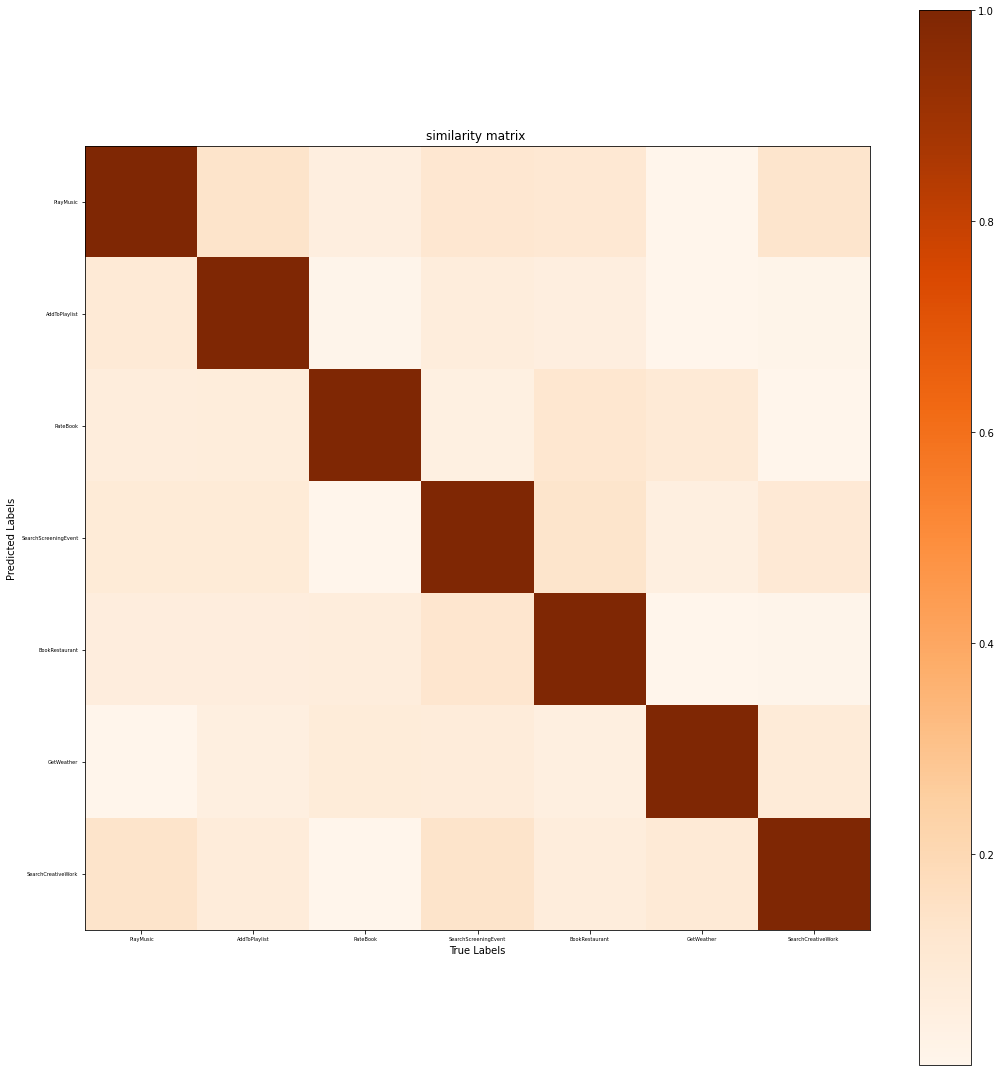

In [9]:
'''相似度矩阵绘制'''
def similar_matrix_plot(concent_params, num_classes, labels):#绘制混淆矩阵
    matrix = concent_params.numpy()  #先放在numpy上才能作图
    plt.figure(figsize=(15,15))  #设置画布大小
    plt.imshow(matrix, cmap=plt.cm.Oranges)
  
    # 设置x轴坐标label
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, labels,fontsize=5)
    plt.yticks(tick_marks, labels,fontsize=5)
        # 显示colorbar
    plt.colorbar()
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('similarity matrix ')

    plt.tight_layout()
    plt.show()

similar_matrix_plot(concent_params, len(train_original_labels), labels)

In [10]:
'''读取OOD的wiki103数据'''
import os
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

paragraphs = _read_wiki('./wiki103')

'''将读取的wiki数据tokenize'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
tokens = []
datas_size = len(paragraphs)
for l in tqdm(range(datas_size)):
    for k in range(len(paragraphs[l])):
        text = paragraphs[l][k]
        text = tokenizer.tokenize(text)
        token = tokenizer.convert_tokens_to_ids(text)
        tokens.append(token)

ood_num = 16000
ood_datas = []
temp = [[] for i in range(len(tokens))] #这样防止temp和tokens地址相同
for i in range(len(tokens)):
    temp[i] = tokens[i]
for i in range(ood_num):  #Bert最长读512最少读2长度的tokens,所以要处理
    if len(temp[i]) <98 and len(temp[i])>2:
        ood_datas.append(temp[i])
        
print(len(ood_datas))

100%|██████████| 760542/760542 [20:42<00:00, 612.02it/s]


15774


In [11]:
'''训练DI生成模型'''
def train_DI_gen(dir_samples, ood_data, DI_gen, optimizer, loss_func, loss_func2, label, temper=10, error=1.2, max_iter=True):
    device = 'cuda:1'
    DI_gen = DI_gen.to(device)
    loss_num=999
    tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
    DI_gen.train()
    for i in range(len(dir_samples)):
        count = 0
        ood_data = ood_data.view(-1,1).to(device)
        #z = torch.randn(30,1).to(device)
        tokens_gens=torch.tensor([]).to(device) #选择最小损失的tokens
        losses = torch.tensor([]) #保存对应的损失
        while loss_num > error:  
            
            if max_iter == True and count>=300:  #是否设置最大迭代次数1200
                break
            
            optimizer.zero_grad()
            
            label = label.to(device).long()
            dir_sample = dir_samples[i].to(device).view(1,-1)
            
            probs, tokens_gen = DI_gen(ood_data)
            
            #loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_sample)
            #loss = 0.6*loss_func2(probs, label)
            loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_sample) + 0.6*loss_func2(probs, label) #如果不加后面的硬性指标会使得预测的标签混乱
            loss_num = loss.item()
            
            loss.requires_grad_(True) #这里应该是因为如果将最后一层的模型参数梯度关闭，则计算出来的loss也没有梯度，不能追踪，所以要将loss的梯度设置为True
            loss.backward()
            optimizer.step()
            count += 1
            
            if count%2==0:
                tokens_gens = torch.cat([tokens_gens, tokens_gen], dim=0)
                losses = torch.cat([losses, torch.tensor([loss_num])])
                #print(loss_num)
        #print('训练过程中bert_cnn的预测情况'+str(torch.argmax(probs)))
            
    if max_iter == True and len(tokens_gens) > 0:
        tokens_gen = tokens_gens[torch.argmin(losses).item()]  #选择loss最小的
            
    return tokens_gen
        

In [12]:
'''定义理想情况，DI数据应该对应的真实标签'''
DI_num = len(ood_datas)
DI_labels = torch.tensor([])
for i in range(len(train_original_labels)):
    for k in [1,5]:
        for j in range(int(DI_num/len(train_original_labels)/2)):
            DI_labels = torch.cat([DI_labels, torch.tensor([i])])

In [13]:
'''定义DI的生成模型，以及损失函数和优化器'''
DI_gen = DI_Gen_model(teacher_model)
loss_func = nn.KLDivLoss(reduction = 'mean')
loss_func2 = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(DI_gen.parameters(), lr=1e-5)

'''生成训练集的DI'''
DI_num = len(ood_datas)
DI_datas = torch.tensor([])
ood_idx = 0
for i in range(len(train_original_labels)):  #标签的idx刚好和train_original_labels的下标顺序对应

    for k in [0.5,0.8]:  #每种β生成1/2的数据
        m = Dirichlet(k*concent_params[i])  #采样每个类的数据
        
        for j in tqdm(range(int(DI_num/len(train_original_labels)/2))):
            x = m.sample().view(1,-1)
            
            DI_gen = DI_Gen_model(teacher_model)
            optimizer = torch.optim.SGD(DI_gen.parameters(), lr=1e-5)
            
            tokens = train_DI_gen(x, torch.tensor(ood_datas[ood_idx]), DI_gen, optimizer, loss_func, loss_func2, torch.tensor([i]))
            ood_idx += 1
            
            tokens = tokens.squeeze().tolist()
            while len(tokens)<100:
                tokens.append(0)  #padding到100
        
            tokens = torch.tensor(tokens)
            DI_datas = torch.cat([DI_datas, tokens.to('cpu').view(1,-1)], dim=0)
            
            '''
            bert_cnn.eval()
            bert_cnn = bert_cnn.to('cuda:1')
            with torch.no_grad():
                out = bert_cnn(tokens.to('cuda:1').long().view(1,-1))
                print('当前bert_cnn对本token的预测情况'+str(torch.argmax(F.softmax(out), dim=1)))
            
            bert_cnn.eval()
            bert_cnn = bert_cnn.to('cuda:1')
            with torch.no_grad():
                out = bert_cnn(DI_datas.to('cuda:1').long())
                print(torch.argmax(F.softmax(out), dim=1))
            '''


  0%|          | 0/1126 [00:00<?, ?it/s]/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1126/1126 [04:09<00:00,  4.50it/s]


In [14]:
'''随机测试DI对应的英文'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
text = tokenizer.convert_ids_to_tokens(DI_datas[10].tolist())
print(text)

DI_datasets = TensorDataset(DI_datas.long())
DI_datasets = DataLoader(DI_datasets, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

'''观察生成DI数据的预测标签特性'''
teacher_model.eval()
teacher_model = teacher_model.to('cuda:1')
DI_pred_labels = torch.tensor([])
with torch.no_grad():
    for i, data in enumerate(DI_datasets):
        out = teacher_model(data[0].to('cuda:1').long())
        DI_pred = torch.argmax(F.softmax(out), dim=1) #DI数据输入到bert_cnn中对应的标签
        DI_pred_labels = torch.cat([DI_pred_labels, DI_pred.to('cpu')])

DI_pred_dict = {} #记录DI预测的不同种类标签个数
for i in range(len(train_original_labels)):
    DI_pred_dict[i] = 0
for i in range(len(DI_pred_labels)):
    DI_pred_dict[DI_pred_labels[i].item()] += 1 
print(DI_pred_dict)

['[CLS]', '##wing', 'neared', '##bry', 'iata', 'ft', 'indus', 'cardiff', 'carefully', '[unused265]', 'accompanying', '##nse', 'mixer', 'hereditary', 'hear', 'teaser', 'lil', 'crowns', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


{0: 181, 1: 856, 2: 274, 3: 1814, 4: 105, 5: 4267, 6: 8267}


In [15]:
'''将DI文件装入Dataloader中'''
DI_datasets = TensorDataset(DI_datas.long(), DI_pred_labels.long())
DI_datasets = DataLoader(DI_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

In [16]:
student_model.eval()
student_model = student_model.to('cuda:1')
with torch.no_grad():
    for i , data in enumerate(DI_datasets):
        test_output = student_model(data[0].to('cuda:1'))
        x = data[0]

In [17]:
print(torch.argmax(F.softmax(test_output, dim=1), dim=1))
indexs = torch.argmax(F.softmax(test_output, dim=1), dim=1).to('cpu')
print(F.softmax(test_output, dim=1))

tensor([6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 6, 1, 2, 3, 6, 6, 4, 4, 1, 4, 6, 6,
        2, 6, 6, 6, 6, 5, 6, 1, 6, 6, 1, 1, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 1, 4,
        1, 6, 1, 1, 1, 4, 1, 6, 6, 1, 2, 6, 1, 6, 1, 1, 1, 0, 2, 1, 3, 1, 3, 6,
        1, 6, 6, 6, 1, 6, 6, 4, 1, 1, 3, 4, 1, 3, 2, 1, 4, 2, 6, 6, 4, 6, 2, 6,
        6, 6, 6, 0, 6, 1, 1, 1, 6, 1, 1, 1, 6, 6, 4, 6, 6, 6, 6, 1, 1, 1, 2, 0,
        6, 6, 6, 6, 1, 6, 2, 6], device='cuda:1')
tensor([[0.0553, 0.2640, 0.0895, 0.0497, 0.0754, 0.0230, 0.4431],
        [0.1599, 0.1461, 0.0306, 0.1152, 0.0254, 0.0352, 0.4877],
        [0.0594, 0.1260, 0.1983, 0.1856, 0.0251, 0.0205, 0.3851],
        [0.0537, 0.1401, 0.0985, 0.0327, 0.0534, 0.0140, 0.6075],
        [0.0357, 0.0611, 0.4207, 0.0579, 0.0229, 0.2111, 0.1905],
        [0.0332, 0.2140, 0.0598, 0.0249, 0.0405, 0.0577, 0.5699],
        [0.0302, 0.2355, 0.0545, 0.0243, 0.0295, 0.0160, 0.6100],
        [0.0404, 0.0354, 0.0514, 0.0427, 0.0263, 0.0190, 0.7848],
        [0.0908, 0.268

In [18]:
for i in range(len(indexs)):
    print(F.softmax(test_output, dim=1)[i][indexs[i]])

tensor(0.4431, device='cuda:1')
tensor(0.4877, device='cuda:1')
tensor(0.3851, device='cuda:1')
tensor(0.6075, device='cuda:1')
tensor(0.4207, device='cuda:1')
tensor(0.5699, device='cuda:1')
tensor(0.6100, device='cuda:1')
tensor(0.7848, device='cuda:1')
tensor(0.3249, device='cuda:1')
tensor(0.5795, device='cuda:1')
tensor(0.6193, device='cuda:1')
tensor(0.4768, device='cuda:1')
tensor(0.4703, device='cuda:1')
tensor(0.3470, device='cuda:1')
tensor(0.4409, device='cuda:1')
tensor(0.2898, device='cuda:1')
tensor(0.5699, device='cuda:1')
tensor(0.7313, device='cuda:1')
tensor(0.3315, device='cuda:1')
tensor(0.2539, device='cuda:1')
tensor(0.6431, device='cuda:1')
tensor(0.2793, device='cuda:1')
tensor(0.7459, device='cuda:1')
tensor(0.6351, device='cuda:1')
tensor(0.7051, device='cuda:1')
tensor(0.5493, device='cuda:1')
tensor(0.3405, device='cuda:1')
tensor(0.7456, device='cuda:1')
tensor(0.6202, device='cuda:1')
tensor(0.2905, device='cuda:1')
tensor(0.6798, device='cuda:1')
tensor(0

In [19]:
student_model.eval()
student_model = student_model.to('cuda:1')
with torch.no_grad():
    count = 0
    test_num = 0
    for i , data in enumerate(DI_datasets):
        test_output = student_model(data[0].to('cuda:1'))
        idxs = torch.argmax(F.softmax(test_output, dim=1), dim=1).to('cpu')
        for j in range(len(idxs)):
            if F.softmax(test_output, dim=1)[j][idxs[j]] > 0.80:
                count+=1
            test_num += 1
print(count)
print(test_num)

501
15744


In [20]:
'''尝试2019DI的zero-shot蒸馏student模型的训练函数
参数：
teacher_model:被提取的模型
student_model:要提取出的模型
datas:DI生成的数据，用Dataloader封装
optimizer:优化器，只优化student_model的参数
loss_func:采用KL散度，或是MSE等保持teacher和student的softmax输出的相似性
temper:KL散度的温度系数,不能设置太高，经过实验探究，设置到4左右效果最好
'''
def train_KD_student(teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs , train_original_datas, dev_original_datas, test_original_datas):
    device = 'cuda:1'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []
    
    max_acc_fin = 0 #记录最终最大精度测试集组并输出
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    for epoch in tqdm(range(epochs)):
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            student_model.train()
            tokens = data[0].to(device)
            #labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
            with torch.no_grad():
                probs_teacher = teacher_model(tokens)
            
            probs_student = student_model(tokens)
            
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1))
            #loss = 0.8*loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.2*loss_func2(probs_student, labels)
            loss.backward()  #这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            print(loss.item())
            
            student_model.eval()
            accuracy_test, _ = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train().eval_for_incremental(student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
               

In [21]:
'''定义用zero-shot KD训练的student模型和损失函数和优化器'''

print('*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')

bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

accuracy_train, _ = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, _ = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, _ = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print(accuracy_train)
print(accuracy_dev)
print(accuracy_test)

train_KD_student(teacher_model, bert_student, DI_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)
#train_KD_student(bert_cnn, bert_cnn_student, DI_datasets_padding, optimizer, loss_func, loss_func2, 5, 30) #用padding后的DI来KD，对比OOD

*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************
0.15785845588235295
0.146875
0.1890625


  0%|          | 0/30 [00:00<?, ?it/s]

0.02571248821914196
0.01910116709768772
0.018585555255413055
0.016676798462867737
0.015812424942851067
0.0162481851875782
0.015829753130674362
0.016160668805241585
0.017536470666527748
0.014748819172382355
0.0148018728941679
0.015269242227077484
0.015016848221421242
0.014523966237902641
0.015858180820941925
0.015951400622725487
0.016102775931358337
0.01661938987672329
0.014664294198155403
0.01503952406346798
0.014029497280716896
0.017308970913290977
0.014625558629631996
0.015420431271195412
0.01516978070139885
0.015532506629824638
0.01561178732663393
0.013138297013938427
0.014398972503840923
0.016364162787795067
0.015509906224906445
0.016938326880335808
0.014288539066910744
0.015298273414373398
0.015448315069079399
0.015274960547685623
0.014468126930296421
0.01564685069024563
0.01577610708773136
0.016215994954109192
0.01531071588397026
0.015447360463440418
0.014463823288679123
0.015722282230854034
0.014824886806309223
0.01375756785273552
0.014837557449936867
0.015196917578577995
0.0134

  3%|▎         | 1/30 [01:41<49:11, 101.76s/it]

训练集精度0.21576286764705882
验证集精度0.2140625
测试集精度0.221875
0.014216997660696507
0.01594926416873932
0.014981255866587162
0.014498132281005383
0.014492022804915905
0.01495371200144291
0.014104021713137627
0.013701241463422775
0.012816151604056358
0.013382398523390293
0.01428559236228466
0.013368814252316952
0.014364279806613922
0.013937268406152725
0.014200049452483654
0.013363425619900227
0.013389921747148037
0.014548186212778091
0.013250594027340412
0.015323543921113014
0.01243915967643261
0.01414564624428749
0.015464527532458305
0.013938860036432743
0.012417887337505817
0.015046665444970131
0.013772288337349892
0.012721171602606773
0.013259081169962883
0.013034659437835217
0.013174089603126049
0.013966151513159275
0.013243007473647594
0.015291236340999603
0.013928729109466076
0.013180122710764408
0.01392343919724226
0.01339713018387556
0.01316882949322462
0.013620519079267979
0.013270925730466843
0.012220705859363079
0.014177271164953709
0.013528556562960148
0.014235477894544601
0.0127146

  7%|▋         | 2/30 [04:05<59:04, 126.58s/it]

训练集精度0.48651960784313725
验证集精度0.5203125
测试集精度0.490625
0.012078351341187954
0.013045265339314938
0.012573414482176304
0.013343824073672295
0.01142587885260582
0.013338396325707436
0.01325952634215355
0.013215754181146622
0.0129786292091012
0.011795801110565662
0.01322492677718401
0.011861169710755348
0.013196561485528946
0.012516746297478676
0.012341323308646679
0.012431592680513859
0.013149772770702839
0.01165821123868227
0.012027299031615257
0.0107567198574543
0.011851919814944267
0.011907086707651615
0.013070636428892612
0.01313210092484951
0.01297077164053917
0.012968268245458603
0.013207504525780678
0.011919003911316395
0.012753043323755264
0.012346772477030754
0.011679518967866898
0.01200845930725336
0.01234533078968525
0.011831509880721569
0.011535423807799816
0.010767376981675625
0.011872961185872555
0.013254634104669094
0.012320431880652905
0.011646530590951443
0.011797952465713024
0.012202653102576733
0.012536836788058281
0.012611777521669865
0.013112564571201801
0.01282459031

 10%|█         | 3/30 [06:21<58:52, 130.84s/it]

训练集精度0.7090992647058824
验证集精度0.7140625
测试集精度0.6953125
0.01083403266966343
0.011008286848664284
0.012614638544619083
0.011927071027457714
0.012449598871171474
0.011916467919945717
0.01125070359557867
0.01227556262165308
0.011765901930630207
0.012021590024232864
0.010979963466525078
0.010870346799492836
0.011349129490554333
0.01048305444419384
0.01137826032936573
0.013507585972547531
0.01217105332762003
0.011361303739249706
0.011926984414458275
0.010874231345951557
0.012158219702541828
0.012849061749875546
0.012972978875041008
0.011721504852175713
0.010829772800207138
0.011633319780230522
0.012005343101918697
0.012372879311442375
0.01169623527675867
0.01135179027915001
0.011400512419641018
0.00999376643449068
0.011469509452581406
0.011762739159166813
0.011494269594550133
0.012290740385651588
0.010793598368763924
0.011391597799956799
0.011923292651772499
0.012226875871419907
0.011655236594378948
0.011087807826697826
0.011682369746267796
0.01257597841322422
0.011963955126702785
0.011038523

 13%|█▎        | 4/30 [08:08<52:31, 121.21s/it]

训练集精度0.7621017156862745
验证集精度0.7671875
测试集精度0.759375
0.011684746481478214
0.01181316003203392
0.01256705541163683
0.00992601364850998
0.010640661232173443
0.011576375924050808
0.011294293217360973
0.011539792641997337
0.010943680070340633
0.011875970289111137
0.010809489525854588
0.011050725355744362
0.01198747381567955
0.011435536667704582
0.011265653185546398
0.011270730756223202
0.011916802264750004
0.010991568677127361
0.010611982084810734
0.010565007105469704
0.010815885849297047
0.010656689293682575
0.011239421553909779
0.010813507251441479
0.011816785670816898
0.01210733875632286
0.012068766169250011
0.009969155304133892
0.012036992236971855
0.012643123045563698
0.010004988871514797
0.010728604160249233
0.012388368137180805
0.010978451929986477
0.011509732343256474
0.011611574329435825
0.011466508731245995
0.011079388670623302
0.011245803907513618
0.01050021592527628
0.01077487226575613
0.011334332637488842
0.011778313666582108
0.010228225961327553
0.010318380780518055
0.0108059

 17%|█▋        | 5/30 [09:54<48:14, 115.78s/it]

训练集精度0.7715226715686274
验证集精度0.7734375
测试集精度0.746875
0.010414588265120983
0.01196594163775444
0.011224319227039814
0.011015471071004868
0.010806748643517494
0.010115480050444603
0.01058635301887989
0.011525082401931286
0.01179027371108532
0.011156255379319191
0.012458818964660168
0.011889043264091015
0.011960775591433048
0.012146464549005032
0.011644823476672173
0.010934267193078995
0.011241326108574867
0.011979210190474987
0.011816231533885002
0.012034859508275986
0.011669730767607689
0.011119622737169266
0.011015789583325386
0.010295342653989792
0.009912941604852676
0.011099617928266525
0.012021570466458797
0.011885765008628368
0.011457918211817741
0.011284658685326576
0.01092187687754631
0.011369760148227215
0.010656480677425861
0.011118843220174313
0.010278625413775444
0.010625693015754223
0.010954962112009525
0.01019410602748394
0.011446909047663212
0.010970809496939182
0.011996482498943806
0.011762174777686596
0.011480452492833138
0.010591013357043266
0.010240700095891953
0.01043

 20%|██        | 6/30 [11:47<45:59, 114.97s/it]

训练集精度0.8311121323529411
验证集精度0.853125
测试集精度0.8171875
0.011636817827820778
0.0096191531047225
0.01067641656845808
0.010082167573273182
0.010821997188031673
0.00981762632727623
0.009734243154525757
0.012017940171062946
0.009765800088644028
0.01210195291787386
0.010542456991970539
0.010033409111201763
0.010847707279026508
0.010766587220132351
0.011314726434648037
0.01041066087782383
0.010547121055424213
0.011043081060051918
0.010671067051589489
0.011710520833730698
0.010622969828546047
0.011697573587298393
0.011109109036624432
0.011684434488415718
0.010924236848950386
0.009507851675152779
0.01008562371134758
0.010712860152125359
0.011151213198900223
0.01171976700425148
0.010946557857096195
0.01099895779043436
0.011210435070097446
0.011158839799463749
0.011908303014934063
0.01099089439958334
0.01121914479881525
0.012533235363662243
0.01115402765572071
0.011448553763329983
0.009975492022931576
0.010198460891842842
0.010546265169978142
0.012469913810491562
0.011046167463064194
0.011051202192

 23%|██▎       | 7/30 [13:36<43:19, 113.02s/it]

训练集精度0.8385416666666666
验证集精度0.8546875
测试集精度0.8265625
0.010512365028262138
0.010187743231654167
0.011131610721349716
0.00972731877118349
0.012287352234125137
0.012465898878872395
0.01054264884442091
0.011330575682222843
0.009701031260192394
0.010270101949572563
0.010544941760599613
0.01108559314161539
0.01065037865191698
0.01063169352710247
0.009097072295844555
0.011513405479490757
0.011277156881988049
0.010768208652734756
0.010614651255309582
0.011483301408588886
0.010719059966504574
0.010831090621650219
0.00993423443287611
0.011307301931083202
0.011763965710997581
0.010827523656189442
0.009958302602171898
0.010234443470835686
0.010347372852265835
0.010046829469501972
0.010837775655090809
0.010204247198998928
0.011150235310196877
0.011168623343110085
0.010128681547939777
0.012131313793361187
0.010841960087418556
0.012676739133894444
0.009881552308797836
0.010672749020159245
0.010787677019834518
0.009801937267184258
0.010468645952641964
0.009720309637486935
0.00997451227158308
0.009420

 27%|██▋       | 8/30 [15:16<39:55, 108.89s/it]

训练集精度0.8348651960784313
验证集精度0.846875
测试集精度0.828125
0.010680449195206165
0.010256989859044552
0.010853911750018597
0.011038567870855331
0.010917711071670055
0.01187821850180626
0.010461588390171528
0.011432716622948647
0.01133250817656517
0.011323150247335434
0.010821116156876087
0.010819745250046253
0.010488159023225307
0.010723325423896313
0.01006161980330944
0.01003061793744564
0.01044419500976801
0.009646805003285408
0.009869290515780449
0.010057544335722923
0.010584408417344093
0.009429576806724072
0.009434682317078114
0.011932270601391792
0.011816506274044514
0.010679132305085659
0.01216620672494173
0.010159674100577831
0.011731956154108047
0.011125669814646244
0.011463457718491554
0.01039858814328909
0.011461267247796059
0.010901909321546555
0.010536516085267067
0.011529160663485527
0.010367043316364288
0.010235357098281384
0.010700042359530926
0.010025492869317532
0.009998118504881859
0.009938712231814861
0.010166466236114502
0.010631310753524303
0.0100887231528759
0.0105714732

 30%|███       | 9/30 [16:53<36:44, 104.99s/it]

训练集精度0.8465839460784313
验证集精度0.859375
测试集精度0.8421875
0.011227373965084553
0.010705904103815556
0.010473070666193962
0.01020355150103569
0.011456144973635674
0.010468677617609501
0.009684707969427109
0.01040344126522541
0.010697061195969582
0.01172487810254097
0.010457935743033886
0.011780121363699436
0.010493398644030094
0.011466721072793007
0.01223744172602892
0.009963737800717354
0.012140193954110146
0.010907473042607307
0.011330107226967812
0.009909356012940407
0.011418977752327919
0.010794046334922314
0.011514331214129925
0.011632234789431095
0.009402072988450527
0.011328269727528095
0.01053455751389265
0.010905285365879536
0.01019174512475729
0.010808466002345085
0.009774582460522652
0.009525245986878872
0.010354924015700817
0.009820337407290936
0.011162121780216694
0.011798350140452385
0.009918472729623318
0.010374028235673904
0.010776529088616371
0.01136434730142355
0.011553140357136726
0.009888420812785625
0.010132568888366222
0.010382194072008133
0.010619661770761013
0.0098769

 33%|███▎      | 10/30 [18:39<35:09, 105.50s/it]

训练集精度0.867953431372549
验证集精度0.8703125
测试集精度0.853125
0.010087145492434502
0.011158806271851063
0.009960871189832687
0.011702288873493671
0.011832163669168949
0.010194465517997742
0.00986681692302227
0.010551009327173233
0.010793296620249748
0.009790996089577675
0.010123802348971367
0.011041897349059582
0.009832987561821938
0.009013763628900051
0.011673329398036003
0.010149521753191948
0.01020733080804348
0.011581904254853725
0.009145285934209824
0.010457942262291908
0.012292402796447277
0.010532640852034092
0.00973624549806118
0.009418129920959473
0.01060883142054081
0.010427895933389664
0.01020132564008236
0.010240553878247738
0.010360809974372387
0.01155105885118246
0.010393261909484863
0.008946261368691921
0.010141781531274319
0.010323632508516312
0.009414197877049446
0.010524417273700237
0.01064325962215662
0.011875064112246037
0.010464509017765522
0.010568100027740002
0.011678474023938179
0.01066560111939907
0.010006201453506947
0.010288042947649956
0.009168876335024834
0.010813128

 37%|███▋      | 11/30 [20:11<32:05, 101.34s/it]

训练集精度0.8570006127450981
验证集精度0.871875
测试集精度0.8546875
0.009983660653233528
0.009999755769968033
0.010844316333532333
0.010208827443420887
0.010073858313262463
0.009459792636334896
0.010649449191987514
0.010753670707345009
0.010181210935115814
0.009669622406363487
0.01136109884828329
0.010354178957641125
0.011616573669016361
0.009950865991413593
0.010314379818737507
0.010286842472851276
0.010171730071306229
0.010203617624938488
0.010536272078752518
0.010867652483284473
0.009936675429344177
0.01006606686860323
0.010414806194603443
0.011582176201045513
0.010291270911693573
0.011723693460226059
0.010218439623713493
0.00993155688047409
0.009941956028342247
0.010941488668322563
0.011211786419153214
0.011710463091731071
0.010726108215749264
0.012119541876018047
0.01150360144674778
0.011494548059999943
0.010091735050082207
0.010630724020302296
0.011070228181779385
0.010284226387739182
0.011715861968696117
0.011410851031541824
0.010214022360742092
0.010898630134761333
0.010919547639787197
0.0094

 40%|████      | 12/30 [21:58<30:51, 102.88s/it]

训练集精度0.8780637254901961
验证集精度0.884375
测试集精度0.8640625
0.011437768116593361
0.010952349752187729
0.010678724385797977
0.010203306563198566
0.009340967983007431
0.01060240063816309
0.009886465966701508
0.010519024915993214
0.011497790925204754
0.010474239476025105
0.01038440503180027
0.010793600231409073
0.010606674477458
0.0099877268075943
0.011186880990862846
0.011298884637653828
0.010736998170614243
0.010209346190094948
0.010943650268018246
0.009855847805738449
0.009747559204697609
0.010688637383282185
0.009074795991182327
0.009865427389740944
0.009393407963216305
0.011256452649831772
0.010667280294001102
0.00999574176967144
0.009989913552999496
0.008032101206481457
0.010651386342942715
0.010779132135212421
0.012471427209675312
0.009720362722873688
0.009951261803507805
0.011536152102053165
0.010893047787249088
0.009825387969613075
0.012355875223875046
0.010016112588346004
0.010303715243935585
0.010068871080875397
0.009825235232710838
0.011071575805544853
0.010560300201177597
0.00953335

 43%|████▎     | 13/30 [23:28<28:02, 98.97s/it] 

训练集精度0.8620557598039216
验证集精度0.86875
测试集精度0.846875
0.010511296801269054
0.011577026918530464
0.010781724937260151
0.011483399197459221
0.010754677467048168
0.01105432491749525
0.01007887627929449
0.010311642661690712
0.010479173623025417
0.01008798461407423
0.010610301047563553
0.010282540693879128
0.009730709716677666
0.010110421106219292
0.011428499594330788
0.01176548469811678
0.008804172277450562
0.010212554596364498
0.010921810753643513
0.012331528589129448
0.010184218175709248
0.010170204564929008
0.00972056109458208
0.010535449720919132
0.010187762789428234
0.00978474598377943
0.010993225499987602
0.009865264408290386
0.010031825862824917
0.010510860942304134
0.010791626758873463
0.011291862465441227
0.011202347464859486
0.011087063699960709
0.009912088513374329
0.009897472336888313
0.010049630887806416
0.01126012671738863
0.009340768679976463
0.010465024039149284
0.009913762100040913
0.009939970448613167
0.010077977553009987
0.009686904028058052
0.009902690537273884
0.011324655

 47%|████▋     | 14/30 [25:23<27:41, 103.82s/it]

训练集精度0.8883272058823529
验证集精度0.8984375
测试集精度0.86875
0.009832669049501419
0.011077474802732468
0.01047146413475275
0.010618791915476322
0.010634428821504116
0.009489905089139938
0.009285506792366505
0.012059380300343037
0.01082160510122776
0.01086762361228466
0.010564068332314491
0.010390195064246655
0.011292064562439919
0.010121039114892483
0.010874049738049507
0.011530110612511635
0.010126963257789612
0.010904534719884396
0.010228922590613365
0.010189289227128029
0.00949145294725895
0.00958225131034851
0.010316668078303337
0.008950266055762768
0.01003214530646801
0.011227082461118698
0.009984946809709072
0.011789422482252121
0.009899399243295193
0.009570680558681488
0.009577151387929916
0.009704147465527058
0.0116373710334301
0.009228236973285675
0.010172033682465553
0.01010541245341301
0.010260484181344509
0.010340881533920765
0.010635978542268276
0.010681930929422379
0.011587942019104958
0.009744780138134956
0.012068367563188076
0.010242590680718422
0.010893972590565681
0.0100616011

 50%|█████     | 15/30 [26:59<25:22, 101.48s/it]

训练集精度0.8741574754901961
验证集精度0.8859375
测试集精度0.8546875
0.010053429752588272
0.010945410467684269
0.009300007484853268
0.009254630655050278
0.008600827306509018
0.010129550471901894
0.01041578408330679
0.010150532238185406
0.0105313491076231
0.010445458814501762
0.011572974734008312
0.009897938929498196
0.010758926160633564
0.010380417108535767
0.011195708066225052
0.009698424488306046
0.011232306249439716
0.009944085963070393
0.010712926276028156
0.011303480714559555
0.009781250730156898
0.009562588296830654
0.011222067289054394
0.01065701525658369
0.010652923956513405
0.010052836500108242
0.010601017624139786
0.012007064186036587
0.009575853124260902
0.01152487751096487
0.010277565568685532
0.01156499795615673
0.012538514100015163
0.010857300832867622
0.010599062778055668
0.011080301366746426
0.010173672810196877
0.009462420828640461
0.010212326422333717
0.009854251518845558
0.010718469507992268
0.009380728006362915
0.010720370337367058
0.0095753138884902
0.010544238612055779
0.0094778

 53%|█████▎    | 16/30 [28:41<23:44, 101.76s/it]

训练集精度0.8642769607843137
验证集精度0.8703125
测试集精度0.8546875
0.009073952212929726
0.008769359439611435
0.009740251116454601
0.010385188274085522
0.010226286016404629
0.00955996848642826
0.009295761585235596
0.010519764386117458
0.010987718589603901
0.009410426020622253
0.011733775027096272
0.011757533997297287
0.009591607376933098
0.009950768202543259
0.011214791797101498
0.01069915946573019
0.010159803554415703
0.011205589398741722
0.010188567452132702
0.01116278674453497
0.010704418644309044
0.011723378673195839
0.012081785127520561
0.010757672600448132
0.009827769361436367
0.010973145253956318
0.010331335477530956
0.010388624854385853
0.0103556327521801
0.010399705730378628
0.009762055240571499
0.009661017917096615
0.01063954271376133
0.0096906628459692
0.010030522011220455
0.00881129503250122
0.009270334616303444
0.010528855957090855
0.011821005493402481
0.010114176198840141
0.010145541280508041
0.010191654786467552
0.011085004545748234
0.011243290267884731
0.009730598889291286
0.01088995

 57%|█████▋    | 17/30 [30:17<21:39, 99.98s/it] 

训练集精度0.8780637254901961
验证集精度0.88125
测试集精度0.8671875
0.008583614602684975
0.010217869654297829
0.009666148573160172
0.009985989890992641
0.010671411640942097
0.010266122408211231
0.01028301753103733
0.009764154441654682
0.010383970104157925
0.010342496447265148
0.010174822062253952
0.009693610481917858
0.011171911843121052
0.010013272985816002
0.011492879129946232
0.0101563585922122
0.011125901713967323
0.011033667251467705
0.00981412548571825
0.010439968667924404
0.010147174820303917
0.01034524105489254
0.010633827187120914
0.01309741660952568
0.008361960761249065
0.009688188321888447
0.010228509083390236
0.010140052996575832
0.01033286564052105
0.010347062721848488
0.010743885301053524
0.01059798989444971
0.011476878076791763
0.009618564508855343
0.010751367546617985
0.010715288110077381
0.009798765182495117
0.010379085317254066
0.009869529865682125
0.010964355431497097
0.010797780007123947
0.010383165441453457
0.00981057807803154
0.012133627198636532
0.009771867655217648
0.0093346005

 60%|██████    | 18/30 [32:03<20:22, 101.83s/it]

训练集精度0.8814338235294118
验证集精度0.9015625
测试集精度0.859375
0.010548604652285576
0.009463239461183548
0.010432439856231213
0.009034563787281513
0.011573749594390392
0.009958261623978615
0.01129157654941082
0.00967482291162014
0.010384555906057358
0.00930815190076828
0.011083308607339859
0.01184543501585722
0.011434546671807766
0.010442594066262245
0.010474967770278454
0.01066630519926548
0.009738629683852196
0.011147118173539639
0.010111728683114052
0.011217941530048847
0.009303825907409191
0.010473249480128288
0.009059902280569077
0.011706165038049221
0.011363621801137924
0.009193961508572102
0.010762783698737621
0.007930636405944824
0.009187418036162853
0.01005387119948864
0.010152299888432026
0.010853258892893791
0.009691135957837105
0.010468204505741596
0.010978024452924728
0.010439572855830193
0.009878687560558319
0.009796341881155968
0.010232679545879364
0.010045669041574001
0.011147205717861652
0.011337515898048878
0.01028076559305191
0.009594862349331379
0.009385272860527039
0.0101173

 63%|██████▎   | 19/30 [33:59<19:26, 106.04s/it]

训练集精度0.8803615196078431
验证集精度0.896875
测试集精度0.8703125
0.011599194258451462
0.010749530047178268
0.010833848267793655
0.011877967976033688
0.009947900660336018
0.010819414630532265
0.009837238118052483
0.00938434898853302
0.011066997423768044
0.01019996590912342
0.010779759846627712
0.009045585058629513
0.010084550827741623
0.010311645455658436
0.010775428265333176
0.009105744771659374
0.009775897487998009
0.010016520507633686
0.010392667725682259
0.010071411728858948
0.01210075244307518
0.009532427415251732
0.010480651631951332
0.010368610732257366
0.010477217845618725
0.010613489896059036
0.009408093988895416
0.008749416097998619
0.010524166747927666
0.01005870383232832
0.01063865702599287
0.010672950185835361
0.010616263374686241
0.010890251956880093
0.010864678770303726
0.010170198045670986
0.010839497670531273
0.010365709662437439
0.010095387697219849
0.0102772181853652
0.010959433391690254
0.010094552300870419
0.010198943316936493
0.011725624091923237
0.011324075050652027
0.0101325

 67%|██████▋   | 20/30 [35:33<17:04, 102.49s/it]

训练集精度0.8894761029411765
验证集精度0.8875
测试集精度0.86875
0.009496410377323627
0.010481479577720165
0.010343438014388084
0.010451116599142551
0.01170555129647255
0.010542088188230991
0.011379499919712543
0.011096058413386345
0.010547850281000137
0.009822245687246323
0.011873336508870125
0.009337862022221088
0.010241907089948654
0.011509472504258156
0.009550314396619797
0.010317051783204079
0.010697690770030022
0.009748818352818489
0.010497968643903732
0.009589283727109432
0.01041458360850811
0.010529072023928165
0.010304316878318787
0.010466216132044792
0.009820574894547462
0.010452226735651493
0.009650756604969501
0.00987208541482687
0.01005290262401104
0.00977382529526949
0.009531376883387566
0.010282044298946857
0.010032599791884422
0.010310648009181023
0.009018219076097012
0.009299363940954208
0.01140561792999506
0.010107642970979214
0.009575865231454372
0.009686052799224854
0.010116062127053738
0.010750417597591877
0.009064268320798874
0.009979228489100933
0.009393666870892048
0.0108779836

 70%|███████   | 21/30 [37:05<14:53, 99.31s/it] 

训练集精度0.8761488970588235
验证集精度0.88125
测试集精度0.86875
0.011226928792893887
0.011091220192611217
0.009890755638480186
0.009699776768684387
0.009778427891433239
0.010924953036010265
0.010670225135982037
0.010663690976798534
0.010233374312520027
0.01041176076978445
0.01086872536689043
0.010083409026265144
0.01012708805501461
0.010230747051537037
0.010337102226912975
0.010975110344588757
0.011019105091691017
0.010377569124102592
0.011034037917852402
0.010202070698142052
0.010001404210925102
0.010573395527899265
0.010383282788097858
0.010507161729037762
0.00910712406039238
0.01079135574400425
0.010780224576592445
0.009188566356897354
0.010252400301396847
0.009587563574314117
0.011165221221745014
0.008936208672821522
0.010997430421411991
0.010354212485253811
0.010812921449542046
0.010414345189929008
0.010119656100869179
0.011179749853909016
0.010210439562797546
0.01021563820540905
0.010574148036539555
0.00987370777875185
0.010597760789096355
0.010126537643373013
0.009833193384110928
0.0120919393

 73%|███████▎  | 22/30 [38:47<13:21, 100.17s/it]

训练集精度0.8903952205882353
验证集精度0.9046875
测试集精度0.86875
0.011054063215851784
0.010446508415043354
0.009371642023324966
0.009621239267289639
0.011269772425293922
0.010714631527662277
0.00985806342214346
0.010872283950448036
0.010385164991021156
0.00984923355281353
0.010438001714646816
0.010125654749572277
0.009623244404792786
0.010892770253121853
0.009941304102540016
0.01017578411847353
0.011194068938493729
0.011166990734636784
0.009190578944981098
0.011376670561730862
0.010097677819430828
0.010651071555912495
0.010247522965073586
0.009347017854452133
0.010759779252111912
0.01170263160020113
0.00988439004868269
0.011007162742316723
0.010504243895411491
0.009098827838897705
0.011434407904744148
0.010927113704383373
0.00945289433002472
0.010331006720662117
0.00891908723860979
0.009311359375715256
0.010990390554070473
0.009763737209141254
0.009677504189312458
0.009768682532012463
0.009800723753869534
0.01050157006829977
0.011327367275953293
0.009813502430915833
0.010880488902330399
0.010281390

 77%|███████▋  | 23/30 [40:29<11:45, 100.76s/it]

训练集精度0.8952205882352942
验证集精度0.90625
测试集精度0.884375
0.010327284224331379
0.011092028580605984
0.010500390082597733
0.008335083723068237
0.009930530562996864
0.011969790793955326
0.010425476357340813
0.010362181812524796
0.009914732538163662
0.010284717194736004
0.010840563103556633
0.009853510186076164
0.009748855605721474
0.010262591764330864
0.010012349113821983
0.0115234749391675
0.011247571557760239
0.010950280353426933
0.012007228098809719
0.010028187185525894
0.01096969936043024
0.009461660869419575
0.010744723491370678
0.010672560892999172
0.010325983166694641
0.00997269805520773
0.009429298341274261
0.010564999654889107
0.01013102289289236
0.011476404033601284
0.011248639784753323
0.009111043065786362
0.008808638900518417
0.010318335145711899
0.008915749378502369
0.011246412061154842
0.01064680889248848
0.009504011832177639
0.009409639984369278
0.010569754056632519
0.009641358628869057
0.011287878267467022
0.011424077674746513
0.008495462127029896
0.009514321573078632
0.00907600

 80%|████████  | 24/30 [42:07<09:59, 99.93s/it] 

训练集精度0.8864889705882353
验证集精度0.890625
测试集精度0.8765625
0.010326053015887737
0.010653960518538952
0.010154115036129951
0.011073639616370201
0.010127383284270763
0.010200286284089088
0.009519587270915508
0.009814557619392872
0.01139699388295412
0.010197608731687069
0.01088059600442648
0.010646111331880093
0.010402936488389969
0.010264039039611816
0.01033503096550703
0.009956172667443752
0.01036516111344099
0.010495541617274284
0.009983761236071587
0.010142963379621506
0.0108590517193079
0.010456649586558342
0.010271301493048668
0.009115156717598438
0.010903524234890938
0.009682703763246536
0.010887781158089638
0.010698423720896244
0.011647586710751057
0.009339823387563229
0.011888482607901096
0.010352126322686672
0.008920266292989254
0.01046071108430624
0.010740756057202816
0.01007184199988842
0.009736595675349236
0.009803345426917076
0.009294955059885979
0.00945285428315401
0.00942918285727501
0.00997355580329895
0.010618169791996479
0.010310638695955276
0.010014886036515236
0.00895377900

 83%|████████▎ | 25/30 [43:45<08:17, 99.42s/it]

训练集精度0.8929993872549019
验证集精度0.9
测试集精度0.8859375
0.010247524827718735
0.010652716271579266
0.010209030471742153
0.010534572415053844
0.011297841556370258
0.010164986364543438
0.011349586769938469
0.010213767178356647
0.010108044371008873
0.009955404326319695
0.009820697829127312
0.009026936255395412
0.009113539941608906
0.009046480059623718
0.009739948436617851
0.009647009894251823
0.011408057995140553
0.010428878478705883
0.010541582480072975
0.009417569264769554
0.011424604803323746
0.011136136017739773
0.008783131837844849
0.009628626517951488
0.008910538628697395
0.010574506595730782
0.01030714437365532
0.00973014160990715
0.009321391582489014
0.009279715828597546
0.01035264041274786
0.009123268537223339
0.010136407800018787
0.010127861984074116
0.010060729458928108
0.009872624650597572
0.00921107642352581
0.010042141191661358
0.011721977964043617
0.009682867676019669
0.009576580487191677
0.011178633198142052
0.00993590708822012
0.01002941932529211
0.010149619542062283
0.00963764358

 87%|████████▋ | 26/30 [45:30<06:43, 100.93s/it]

训练集精度0.8890931372549019
验证集精度0.8953125
测试集精度0.878125
0.009608888998627663
0.010301606729626656
0.011219813488423824
0.010174294002354145
0.010671509429812431
0.009673263877630234
0.008418174460530281
0.010260729119181633
0.009747377596795559
0.00995724368840456
0.009648287668824196
0.010316353291273117
0.010792236775159836
0.00998721458017826
0.01137231569737196
0.008499828167259693
0.010460330173373222
0.010391811840236187
0.010659501887857914
0.009752701036632061
0.009235810488462448
0.011730990372598171
0.010290620848536491
0.010993114672601223
0.010594496503472328
0.010173829272389412
0.009962363168597221
0.008783874101936817
0.009560607373714447
0.010594434104859829
0.010892238467931747
0.009510665200650692
0.010145350359380245
0.009967383928596973
0.010157223790884018
0.00979774259030819
0.008294717408716679
0.009066913276910782
0.009718854911625385
0.008672267198562622
0.00963579025119543
0.009380239993333817
0.010261914692819118
0.011257371865212917
0.009415658190846443
0.01141

 90%|█████████ | 27/30 [47:00<04:52, 97.58s/it] 

训练集精度0.905484068627451
验证集精度0.9171875
测试集精度0.884375
0.010589218698441982
0.010109308175742626
0.010515933856368065
0.009846231900155544
0.008835832588374615
0.009395873174071312
0.008494006469845772
0.009998311288654804
0.01022726483643055
0.010840998031198978
0.010206160135567188
0.010289120487868786
0.011271114461123943
0.010349322110414505
0.010759891010820866
0.009096678346395493
0.009463927708566189
0.009819697588682175
0.009917052462697029
0.010646265000104904
0.011675597168505192
0.009909102693200111
0.009024272672832012
0.009039286524057388
0.009391856379806995
0.009634295478463173
0.011219261214137077
0.008560682646930218
0.010745849460363388
0.010137464851140976
0.009230459108948708
0.00980856642127037
0.010438857600092888
0.010414378717541695
0.010875379666686058
0.009918618015944958
0.010324927978217602
0.010607829317450523
0.00993520487099886
0.009970319457352161
0.00969994068145752
0.009301419369876385
0.008655330166220665
0.00965685211122036
0.00884622149169445
0.0117876

 93%|█████████▎| 28/30 [48:47<03:20, 100.46s/it]

训练集精度0.9042585784313726
验证集精度0.909375
测试集精度0.8921875
0.009937746450304985
0.011099722236394882
0.010376853868365288
0.009741604328155518
0.01004322525113821
0.009363673627376556
0.010193748399615288
0.009998786263167858
0.009680325165390968
0.009551642462611198
0.00995945930480957
0.01169669907540083
0.008174476213753223
0.01003179606050253
0.010588597506284714
0.009726363234221935
0.010387099348008633
0.010378038510680199
0.010008582845330238
0.010763523168861866
0.009678594768047333
0.009662702679634094
0.00933983363211155
0.010425557382404804
0.009259817190468311
0.010578682646155357
0.009159854613244534
0.009916788898408413
0.009524037130177021
0.009446506388485432
0.009112168103456497
0.009487967938184738
0.009515434503555298
0.00930026639252901
0.0107454564422369
0.0105563560500741
0.011509778909385204
0.010408339090645313
0.009385217912495136
0.009414177387952805
0.008690345101058483
0.009880205616354942
0.00957350991666317
0.009981122799217701
0.009924394078552723
0.01017691008

 97%|█████████▋| 29/30 [50:23<01:39, 99.06s/it] 

训练集精度0.8954503676470589
验证集精度0.896875
测试集精度0.8859375
0.010498983785510063
0.010315119288861752
0.010824463330209255
0.009470583871006966
0.009358598850667477
0.009852029383182526
0.010359954088926315
0.00971454568207264
0.010291940532624722
0.009820451028645039
0.010241513140499592
0.009654000401496887
0.010702290572226048
0.010211308486759663
0.012160797603428364
0.009249820373952389
0.009083348326385021
0.011469746939837933
0.011239836923778057
0.009963993914425373
0.009907959029078484
0.010120879858732224
0.009870062582194805
0.010294544510543346
0.00924096442759037
0.010833347216248512
0.01065740641206503
0.010916408151388168
0.009768923744559288
0.009879602119326591
0.009889064356684685
0.00984188076108694
0.009267764165997505
0.01126345619559288
0.01084232423454523
0.009967168793082237
0.01093309186398983
0.010961377993226051
0.010458497330546379
0.01029359083622694
0.009578576311469078
0.010366600006818771
0.008427010849118233
0.009647473692893982
0.009154332801699638
0.00967724

100%|██████████| 30/30 [51:54<00:00, 103.82s/it]

训练集精度0.9056372549019608
验证集精度0.9171875
测试集精度0.890625
训练集最终精度0.9042585784313726
验证集最终精度0.909375
测试集最终精度0.8921875


In [22]:
'''读取OOD的wiki103数据'''
import os
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

paragraphs = _read_wiki('./wiki103')

In [23]:
'''将读取的wiki数据tokenize'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
tokens = []
datas_size = len(paragraphs)
for l in tqdm(range(datas_size)):
    for k in range(len(paragraphs[l])):
        text = paragraphs[l][k]
        text = tokenizer.tokenize(text)
        token = tokenizer.convert_tokens_to_ids(text)
        tokens.append(token)

100%|██████████| 760542/760542 [20:28<00:00, 618.89it/s]  


In [24]:
ood_num = 16000
ood_datas = []
temp = [[] for i in range(len(tokens))] #这样防止temp和tokens地址相同
for i in range(len(tokens)):
    temp[i] = tokens[i]
for i in range(ood_num):  #Bert最长读512最少读2长度的tokens,所以要处理
    if len(temp[i]) <98 and len(temp[i])>2:
        temp[i].insert(0,101)
        temp[i].append(102)
        while len(tokens[i]) <100:
            temp[i].append(0)  #padding
        ood_datas.append(temp[i])
        
print(len(ood_datas))

15751


In [25]:
counts =0
for data in ood_datas:
    count = 0
    for j in range(len(data)):
        if data[j] == 0:
            break
        count += 1
    counts += count
ave = counts / len(ood_datas)
print('选取ood数据的平均长度为：'+ str(ave))

选取ood数据的平均长度为：31.243857532855056


In [26]:
ood_datasets = TensorDataset(torch.tensor(ood_datas).long())
ood_datasets = DataLoader(ood_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

In [27]:
OOD_number = 8000
ood_datas_2 = torch.tensor([])

for i,data in enumerate(ood_datasets):
    if len(ood_datas_2) > 8000:
        break
    ood_datas_2 = torch.cat([ood_datas_2, data[0]], dim=0)
ood_datasets_4000 = TensorDataset(ood_datas_2.long())
ood_datasets_4000 = DataLoader(ood_datasets_4000, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

In [28]:
'''用ood数据直接进行KL散度蒸馏studentmodel'''
print('*******************利用ood训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')
bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

train_KD_student(teacher_model, bert_student, ood_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)
accuracy_train, loss_train = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, loss_test = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print('训练集最终精度'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************利用ood训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************


  0%|          | 0/30 [00:00<?, ?it/s]

0.020870793610811234
0.019727371633052826
0.019572243094444275
0.01796109415590763
0.01819884590804577
0.01885722391307354
0.01860547624528408
0.018126003444194794
0.016538331285119057
0.016655689105391502
0.01748432032763958
0.019376317039132118
0.016201060265302658
0.016920065507292747
0.018268505111336708
0.018174557015299797
0.01870163530111313
0.01845458708703518
0.016735684126615524
0.018564498052001
0.017472991719841957
0.01593119092285633
0.0161310862749815
0.01630980148911476
0.016428373754024506
0.015658443793654442
0.016401689499616623
0.016827242448925972
0.017941126599907875
0.016903672367334366
0.016318000853061676
0.016841096803545952
0.015573447570204735
0.016224674880504608
0.016659745946526527
0.014287235215306282
0.0158219076693058
0.015858829021453857
0.015954120084643364
0.01604698784649372
0.015902696177363396
0.015379302203655243
0.016500068828463554
0.014111751690506935
0.016007184982299805
0.0141217652708292
0.016455983743071556
0.014762086793780327
0.015543210

  3%|▎         | 1/30 [02:02<59:12, 122.48s/it]

训练集精度0.5372242647058824
验证集精度0.5390625
测试集精度0.54375
0.013231231831014156
0.012661447748541832
0.013704727403819561
0.013099697418510914
0.014752527698874474
0.013032807968556881
0.013105352409183979
0.013262241147458553
0.012431683950126171
0.01339228730648756
0.011758280918002129
0.013356203213334084
0.01259188074618578
0.012937204912304878
0.0125576825812459
0.012068251147866249
0.015082362107932568
0.012122753076255322
0.0142515879124403
0.012562685646116734
0.010533642023801804
0.011956960894167423
0.012644636444747448
0.012876986525952816
0.012756291776895523
0.013712691143155098
0.013371310196816921
0.010705405846238136
0.013735635206103325
0.013305014930665493
0.012842842377722263
0.012326435185968876
0.012972737662494183
0.01237115915864706
0.012553343549370766
0.012868072837591171
0.011462908238172531
0.011822937056422234
0.011927620507776737
0.012839268893003464
0.012701739557087421
0.01186308078467846
0.012119224295020103
0.013435745611786842
0.013927984051406384
0.012914117

  7%|▋         | 2/30 [04:01<56:16, 120.59s/it]

训练集精度0.6517310049019608
验证集精度0.6484375
测试集精度0.6578125
0.011098736897110939
0.012787293642759323
0.01364772580564022
0.011960174888372421
0.01134293433278799
0.012282597832381725
0.012426099739968777
0.01207147166132927
0.012076403014361858
0.011387692764401436
0.011625329032540321
0.012111843563616276
0.011279428377747536
0.012957886792719364
0.012568953447043896
0.010866457596421242
0.011229468509554863
0.012027769349515438
0.010889226570725441
0.012139415368437767
0.011139918118715286
0.012037844397127628
0.013807528652250767
0.010502762161195278
0.011792351491749287
0.011399203911423683
0.010770880617201328
0.011063313111662865
0.011898192577064037
0.01189750898629427
0.011929777450859547
0.012461360543966293
0.010917050763964653
0.011509894393384457
0.013489254750311375
0.012002742849290371
0.01208232156932354
0.011666659265756607
0.011663686484098434
0.014236358925700188
0.012092909775674343
0.012708408758044243
0.011696573346853256
0.011690749786794186
0.01134214736521244
0.01064

 10%|█         | 3/30 [05:46<50:57, 113.24s/it]

训练集精度0.7084099264705882
验证集精度0.703125
测试集精度0.7265625
0.011238976381719112
0.01148049347102642
0.01073470525443554
0.011514370329678059
0.010883737355470657
0.010067549534142017
0.01298566348850727
0.011281158775091171
0.011230723932385445
0.01143607310950756
0.011466742493212223
0.010461620055139065
0.012642752379179
0.011171017773449421
0.011876830831170082
0.012115132063627243
0.01008705422282219
0.010871113277971745
0.011113128624856472
0.01188703440129757
0.011026037856936455
0.010561132803559303
0.010956024751067162
0.010947625152766705
0.01133002806454897
0.012533767148852348
0.010729100555181503
0.011754666455090046
0.011144435964524746
0.010661976411938667
0.012156580574810505
0.012282016687095165
0.01066962257027626
0.010734411887824535
0.010471003130078316
0.010819163173437119
0.011082044802606106
0.01171577163040638
0.01237077172845602
0.011590764857828617
0.011261221952736378
0.009917490184307098
0.01164217572659254
0.011658999137580395
0.010536924935877323
0.01237492077052

 13%|█▎        | 4/30 [07:29<47:17, 109.15s/it]

训练集精度0.7305453431372549
验证集精度0.71875
测试集精度0.7484375
0.010598368011415005
0.011601181700825691
0.01127376314252615
0.009833921678364277
0.011085528880357742
0.011161040514707565
0.010660474188625813
0.014096280559897423
0.01094684936106205
0.01002978254109621
0.009998761117458344
0.010966531001031399
0.01100426260381937
0.011909951455891132
0.010394906625151634
0.010459702461957932
0.010858891531825066
0.011213908903300762
0.012202437967061996
0.011584627442061901
0.011854169890284538
0.011801166459918022
0.010836531408131123
0.01165674440562725
0.010617620311677456
0.010078098624944687
0.01091421116143465
0.010486098006367683
0.011624506674706936
0.011683856137096882
0.01084519736468792
0.011504380963742733
0.011272923089563847
0.010248755104839802
0.01065718661993742
0.010527555830776691
0.012122384272515774
0.009984675794839859
0.010943339206278324
0.011567125096917152
0.01198688056319952
0.009169306606054306
0.0107176648452878
0.011589419096708298
0.011400462128221989
0.010071069002

 17%|█▋        | 5/30 [09:09<44:11, 106.06s/it]

训练集精度0.7300091911764706
验证集精度0.715625
测试集精度0.75625
0.011147296987473965
0.011953948065638542
0.010831297375261784
0.01106442604213953
0.009283204562962055
0.010966620407998562
0.01184519100934267
0.012272062711417675
0.009512703865766525
0.010848307982087135
0.011714567430317402
0.01025549229234457
0.010659415274858475
0.011052058078348637
0.011286299675703049
0.010992980562150478
0.010378779843449593
0.0102909617125988
0.01098058931529522
0.01084030233323574
0.009148821234703064
0.010921696200966835
0.011214586906135082
0.010745028033852577
0.011659295298159122
0.011422047391533852
0.010479376651346684
0.011683497577905655
0.01111097726970911
0.01206202432513237
0.011234058067202568
0.010304715484380722
0.010003498755395412
0.010339023545384407
0.009378229267895222
0.0118698226287961
0.010823899880051613
0.011403311975300312
0.010872183367609978
0.010679250583052635
0.011521320790052414
0.008735567331314087
0.009844155982136726
0.009757667779922485
0.011903699487447739
0.0107951276004

 20%|██        | 6/30 [10:41<40:30, 101.29s/it]

训练集精度0.7364430147058824
验证集精度0.74375
测试集精度0.7671875
0.010717018507421017
0.010037645697593689
0.010507765226066113
0.010107215493917465
0.00894471537321806
0.009501859545707703
0.010095322504639626
0.011660880409181118
0.009517962113022804
0.010216692462563515
0.009855764918029308
0.009995800442993641
0.012746828608214855
0.00852716714143753
0.012010392732918262
0.010716588236391544
0.011208455078303814
0.011598614975810051
0.010319923050701618
0.009797264821827412
0.01144497748464346
0.00896681472659111
0.011296926066279411
0.011380399577319622
0.009406966157257557
0.010966923087835312
0.009639001451432705
0.011259973980486393
0.009836497716605663
0.010658357292413712
0.010720343329012394
0.011918393895030022
0.00961466133594513
0.011346003971993923
0.0092299310490489
0.011730436235666275
0.010368194431066513
0.008431925438344479
0.009722728282213211
0.010843108408153057
0.010678650811314583
0.010561207309365273
0.011092430911958218
0.010324983857572079
0.011613928712904453
0.00913705

 23%|██▎       | 7/30 [12:14<37:45, 98.51s/it] 

训练集精度0.7395067401960784
验证集精度0.7390625
测试集精度0.7625
0.01196411531418562
0.010035896673798561
0.009622462093830109
0.01031543966382742
0.010926973074674606
0.01074024848639965
0.010947717353701591
0.010736272670328617
0.01040644571185112
0.009465483948588371
0.012247945182025433
0.010199390351772308
0.010758744552731514
0.009830973111093044
0.010902995243668556
0.009960098192095757
0.011933485046029091
0.009437406435608864
0.00977820809930563
0.009941435419023037
0.010321996174752712
0.009136366657912731
0.010146266780793667
0.009887291118502617
0.00944115687161684
0.009962011128664017
0.008966784924268723
0.010577622801065445
0.01012082677334547
0.010664899833500385
0.010333007201552391
0.009924964979290962
0.009338892064988613
0.01006857305765152
0.010568561032414436
0.009831098839640617
0.01057005301117897
0.009928595274686813
0.010340488515794277
0.00904166977852583
0.01182484906166792
0.009052494540810585
0.01012257020920515
0.009724321775138378
0.01089413557201624
0.009504484944045

 27%|██▋       | 8/30 [13:50<35:51, 97.82s/it]

训练集精度0.7535232843137255
验证集精度0.759375
测试集精度0.771875
0.010786629281938076
0.010289713740348816
0.010761699639260769
0.010638153180480003
0.008674259297549725
0.011318011209368706
0.009643844328820705
0.010473912581801414
0.010519806295633316
0.009213222190737724
0.009548489935696125
0.011203660629689693
0.01011419016867876
0.009457672946155071
0.011414434760808945
0.012076887302100658
0.00985769648104906
0.010753572918474674
0.011745811440050602
0.01073488686233759
0.010343213565647602
0.00970742478966713
0.011196700856089592
0.009041781537234783
0.010763166472315788
0.01025584526360035
0.009429250843822956
0.010878792963922024
0.009361954405903816
0.010665742680430412
0.009075652807950974
0.011083575896918774
0.011592891067266464
0.011159190908074379
0.01009456068277359
0.009601714089512825
0.010255892761051655
0.011564946733415127
0.01065159123390913
0.009509395807981491
0.011586192063987255
0.010164925828576088
0.008963771164417267
0.01016474049538374
0.009320009499788284
0.010032194

 30%|███       | 9/30 [15:23<33:39, 96.19s/it]

训练集精度0.7521446078431373
验证集精度0.759375
测试集精度0.7734375
0.009598900564014912
0.009849708527326584
0.011227940209209919
0.010889637283980846
0.010452544316649437
0.009629514068365097
0.009035144932568073
0.009910170920193195
0.010647940449416637
0.010614489205181599
0.009078850969672203
0.008979897946119308
0.010249066166579723
0.0108655309304595
0.010369863361120224
0.010718661360442638
0.008465123362839222
0.009976317174732685
0.010623757727444172
0.01008976623415947
0.010399196296930313
0.008955417200922966
0.010342907160520554
0.011561764404177666
0.009474987164139748
0.009972989559173584
0.00992138497531414
0.010123521089553833
0.01039395947009325
0.010371520183980465
0.009514298290014267
0.009352256543934345
0.010635746642947197
0.010134458541870117
0.009583229199051857
0.011353271082043648
0.011242127977311611
0.010440390557050705
0.010827291756868362
0.011725288815796375
0.008695852011442184
0.010660945437848568
0.009448520839214325
0.009349470026791096
0.010914982296526432
0.01070

 33%|███▎      | 10/30 [16:55<31:39, 94.97s/it]

训练集精度0.7410386029411765
验证集精度0.7375
测试集精度0.7625
0.010202824138104916
0.010145461186766624
0.01059567742049694
0.010736928321421146
0.009662546217441559
0.009849576279520988
0.01023750938475132
0.01064343936741352
0.01090359129011631
0.01118099968880415
0.010518515482544899
0.010101201012730598
0.01065065898001194
0.008772321045398712
0.009872209280729294
0.010934153571724892
0.010510025545954704
0.011238758452236652
0.009741492569446564
0.009759641252458096
0.01046224869787693
0.009608292952179909
0.00944122951477766
0.009731910191476345
0.011170300655066967
0.010120071470737457
0.010394314303994179
0.008225678466260433
0.009874042123556137
0.012221794575452805
0.010110404342412949
0.010320628061890602
0.010161567479372025
0.01057351939380169
0.008882833644747734
0.010317590087652206
0.010241923853754997
0.009114581160247326
0.009479875676333904
0.009862813167273998
0.01019267737865448
0.009096870198845863
0.011112089268863201
0.009438581764698029
0.010671711526811123
0.010775898583233

 37%|███▋      | 11/30 [18:29<29:58, 94.64s/it]

训练集精度0.7588848039215687
验证集精度0.7640625
测试集精度0.7765625
0.010044015944004059
0.010759759694337845
0.008706067688763142
0.009811392985284328
0.009526694193482399
0.010702061466872692
0.009825083427131176
0.010144500061869621
0.0092690484598279
0.009968696162104607
0.010573694482445717
0.010115626268088818
0.010536092333495617
0.009843003004789352
0.010996798053383827
0.010556051507592201
0.00979616865515709
0.009662339463829994
0.008773325011134148
0.009995875880122185
0.009679298847913742
0.009229014627635479
0.01006003376096487
0.01014072448015213
0.011046742089092731
0.008746109902858734
0.00990945752710104
0.01001589372754097
0.010229572653770447
0.01132546178996563
0.008704662322998047
0.009724628180265427
0.009680951945483685
0.010910767130553722
0.00911288894712925
0.010675775818526745
0.010459617711603642
0.009495582431554794
0.010743523016571999
0.010573741048574448
0.010676718316972256
0.01030687429010868
0.012044432573020458
0.008379417471587658
0.011322388425469398
0.009306984

 40%|████      | 12/30 [20:07<28:43, 95.75s/it]

训练集精度0.7711397058823529
验证集精度0.778125
测试集精度0.7796875
0.00996667705476284
0.009821446612477303
0.009403111413121223
0.009486709721386433
0.009060842916369438
0.011304778978228569
0.0115443654358387
0.011489538475871086
0.010946542955935001
0.010045860894024372
0.009188776835799217
0.009161359630525112
0.011076989583671093
0.010304245166480541
0.011701869778335094
0.009081356227397919
0.009016016498208046
0.009098461829125881
0.008411902002990246
0.008929368108510971
0.010349582880735397
0.009279489517211914
0.009417745284736156
0.009583388455212116
0.010253539308905602
0.010408209636807442
0.009949218481779099
0.01050561759620905
0.009592482820153236
0.010570991784334183
0.010777133516967297
0.010251538828015327
0.009966518729925156
0.010848293080925941
0.008879429660737514
0.008850771933794022
0.0109309833496809
0.010768511332571507
0.011197865940630436
0.009678898379206657
0.009375033900141716
0.00927463173866272
0.009770361706614494
0.00906108133494854
0.010635397396981716
0.00895194

 43%|████▎     | 13/30 [21:44<27:09, 95.88s/it]

训练集精度0.7815563725490197
验证集精度0.790625
测试集精度0.79375
0.01054038293659687
0.009646985679864883
0.009067868813872337
0.009692015126347542
0.010516522452235222
0.009753013961017132
0.010833132080733776
0.009888287633657455
0.00956729706376791
0.010283446870744228
0.009359571151435375
0.0105919623747468
0.010216053575277328
0.009588677436113358
0.008784147910773754
0.00804253201931715
0.010797204449772835
0.00970869418233633
0.008880234323441982
0.010096619836986065
0.010656080208718777
0.008717767894268036
0.010813537985086441
0.010159440338611603
0.010175535455346107
0.010640766471624374
0.010121982544660568
0.008258959278464317
0.009612596593797207
0.010725107043981552
0.009732922539114952
0.010340062901377678
0.009524073451757431
0.010159879922866821
0.00958072580397129
0.010868620127439499
0.008425453677773476
0.009086217731237411
0.009015396237373352
0.00994562916457653
0.009566433727741241
0.008461407385766506
0.007800981868058443
0.00938295479863882
0.010356149636209011
0.01031513419

 47%|████▋     | 14/30 [23:27<26:09, 98.07s/it]

训练集精度0.7735906862745098
验证集精度0.75625
测试集精度0.7921875
0.011330890469253063
0.009490265510976315
0.009645526297390461
0.009288436733186245
0.009779681451618671
0.009205636568367481
0.009221217595040798
0.01233928557485342
0.009512684307992458
0.00888749212026596
0.010047651827335358
0.01032901182770729
0.008810557425022125
0.009761108085513115
0.011178581044077873
0.01153336837887764
0.009364101104438305
0.009173180907964706
0.009623602032661438
0.009448578581213951
0.007997865788638592
0.011508182622492313
0.010868648067116737
0.009641183540225029
0.010094930417835712
0.009029265493154526
0.009104462340474129
0.009801745414733887
0.010706744156777859
0.009856126271188259
0.009049377404153347
0.009750112891197205
0.009601086378097534
0.009342974051833153
0.010399064980447292
0.008742858655750751
0.009281396865844727
0.009559417143464088
0.010033026337623596
0.007804701570421457
0.010181046091020107
0.009126517921686172
0.01007874682545662
0.010101010091602802
0.01036488451063633
0.0107760

 50%|█████     | 15/30 [25:09<24:51, 99.42s/it]

训练集精度0.7911305147058824
验证集精度0.78125
测试集精度0.8109375
0.009210128337144852
0.009287341497838497
0.01108101662248373
0.009714005514979362
0.010360266081988811
0.01064972672611475
0.009966522455215454
0.011204845272004604
0.009040728211402893
0.009228798560798168
0.009810060262680054
0.009396355599164963
0.010389779694378376
0.00933217816054821
0.009501002728939056
0.009241881780326366
0.008628368377685547
0.009597293101251125
0.01092336792498827
0.010225096717476845
0.009778467938303947
0.011158601380884647
0.01118063647300005
0.009507556445896626
0.00885998085141182
0.009436754509806633
0.010210325941443443
0.009167114272713661
0.00863664597272873
0.011383724398911
0.009160280227661133
0.009633874520659447
0.010027334094047546
0.00936989113688469
0.009237047284841537
0.010161950252950191
0.00923728384077549
0.010108060203492641
0.008977217599749565
0.009572918526828289
0.010389539413154125
0.010358509607613087
0.00917099416255951
0.009227681905031204
0.01086951233446598
0.008834686130285

 53%|█████▎    | 16/30 [26:50<23:16, 99.73s/it]

训练集精度0.8055300245098039
验证集精度0.809375
测试集精度0.8109375
0.010992352850735188
0.011570432223379612
0.00966852717101574
0.009814588353037834
0.010281150229275227
0.0105442451313138
0.009267198853194714
0.009365307167172432
0.01035283226519823
0.008990203961730003
0.007863051258027554
0.010024001821875572
0.009481828659772873
0.009876652620732784
0.01030090730637312
0.009455478750169277
0.008999546058475971
0.009649021551012993
0.010317057371139526
0.009891084395349026
0.010671737603843212
0.009322932921350002
0.008381441235542297
0.009953441098332405
0.009289070963859558
0.01077972911298275
0.009835412725806236
0.009885615669190884
0.011022309772670269
0.010191483423113823
0.007823450490832329
0.009100941941142082
0.009898252785205841
0.010970980860292912
0.009455767460167408
0.008902661502361298
0.01034607458859682
0.00970759242773056
0.009697379544377327
0.009671020321547985
0.010445392690598965
0.009680463001132011
0.010432749055325985
0.009524192661046982
0.010573787614703178
0.00892756

 57%|█████▋    | 17/30 [28:28<21:30, 99.29s/it]

训练集精度0.7998621323529411
验证集精度0.7953125
测试集精度0.8171875
0.010216757655143738
0.009976188652217388
0.009770721197128296
0.009111715480685234
0.010019960813224316
0.009927542880177498
0.008921432308852673
0.011259867809712887
0.010712424293160439
0.010249867103993893
0.00916901882737875
0.009675068780779839
0.009156091138720512
0.009389877319335938
0.009479032829403877
0.009757086634635925
0.008962063118815422
0.009686975739896297
0.008674997836351395
0.00913950428366661
0.009835919365286827
0.009791316464543343
0.009458323009312153
0.008618826046586037
0.009985973127186298
0.010082703083753586
0.009918383322656155
0.010593225248157978
0.009810122661292553
0.008977925404906273
0.008917883038520813
0.008977264165878296
0.010118281468749046
0.010541095398366451
0.009558458812534809
0.010329540818929672
0.010940877720713615
0.0092298723757267
0.00927842129021883
0.009938368573784828
0.01011052168905735
0.009874780662357807
0.010073746554553509
0.008107682690024376
0.010349612683057785
0.00998

 60%|██████    | 18/30 [30:02<19:34, 97.84s/it]

训练集精度0.8094362745098039
验证集精度0.8140625
测试集精度0.8296875
0.010044300928711891
0.008713174611330032
0.009955818764865398
0.010154533199965954
0.010687057860195637
0.010057361796498299
0.00989187229424715
0.009404865093529224
0.010112173855304718
0.009759850800037384
0.01079507265239954
0.009370828978717327
0.008437609300017357
0.0096581457182765
0.009409919381141663
0.008562001399695873
0.008678581565618515
0.009680412709712982
0.010244120843708515
0.009410033002495766
0.009722888469696045
0.011408800259232521
0.010110639035701752
0.008473062887787819
0.010849718935787678
0.009611648507416248
0.010027779266238213
0.010210609994828701
0.009354385547339916
0.00952906347811222
0.008760024793446064
0.008816009387373924
0.009739021770656109
0.008806390687823296
0.008546561934053898
0.010753894224762917
0.009156434796750546
0.00942312553524971
0.00944032333791256
0.009602467529475689
0.009347456507384777
0.009769442491233349
0.008831243962049484
0.008679589256644249
0.009524164721369743
0.008884

 63%|██████▎   | 19/30 [31:38<17:49, 97.22s/it]

训练集精度0.7974877450980392
验证集精度0.8
测试集精度0.8171875
0.01057514175772667
0.010248932056128979
0.009557938203215599
0.009939718060195446
0.009875123389065266
0.010617454536259174
0.008121797814965248
0.011439776048064232
0.009575184434652328
0.009487088769674301
0.010121680796146393
0.00950314849615097
0.009843965992331505
0.010258413851261139
0.008466148748993874
0.009738913737237453
0.009281255304813385
0.008412463590502739
0.01068654004484415
0.009713138453662395
0.009270284324884415
0.009659331291913986
0.009556794539093971
0.01034626830369234
0.009313298389315605
0.010544833727180958
0.008765100501477718
0.008512062951922417
0.009850721806287766
0.008973854593932629
0.010128344409167767
0.012079920619726181
0.009545032866299152
0.008556286804378033
0.010569347999989986
0.009593314491212368
0.010745019651949406
0.008309255354106426
0.009128030389547348
0.010228388011455536
0.008158320561051369
0.011825325898826122
0.009585978463292122
0.009933462366461754
0.010689493268728256
0.009092341

 67%|██████▋   | 20/30 [33:19<16:22, 98.24s/it]

训练集精度0.8023131127450981
验证集精度0.8125
测试集精度0.8203125
0.010365788824856281
0.010455970652401447
0.010442466475069523
0.010828944854438305
0.009448508732020855
0.010180222801864147
0.00979221798479557
0.01128390897065401
0.009348622523248196
0.010241917334496975
0.010279717855155468
0.010164868086576462
0.009357648901641369
0.011268077418208122
0.009717505425214767
0.010033880360424519
0.008334008976817131
0.010661030188202858
0.010425064712762833
0.008746616542339325
0.010189160704612732
0.009823957458138466
0.01082698442041874
0.008673025295138359
0.010370563715696335
0.010397705249488354
0.009382916614413261
0.010625244118273258
0.01001603715121746
0.010011228732764721
0.009909289889037609
0.009439120069146156
0.00862376019358635
0.008730968460440636
0.00898812711238861
0.009279655292630196
0.009320284239947796
0.009444761089980602
0.009973764419555664
0.009753397665917873
0.008857222273945808
0.009755371138453484
0.008406031876802444
0.008395812474191189
0.00926065631210804
0.009867521

 70%|███████   | 21/30 [34:59<14:49, 98.88s/it]

训练集精度0.8043811274509803
验证集精度0.8078125
测试集精度0.821875
0.009617122821509838
0.010500534437596798
0.011012616567313671
0.011665304191410542
0.010107140988111496
0.011832322925329208
0.010079305619001389
0.011009344831109047
0.009809387847781181
0.009968872182071209
0.008212573826313019
0.010126245208084583
0.008286834694445133
0.007787999697029591
0.009462933987379074
0.007894217036664486
0.007858185097575188
0.010187102481722832
0.009418206289410591
0.008907211944460869
0.009345564059913158
0.010603350587189198
0.007568913046270609
0.008905509486794472
0.009471903555095196
0.008804029785096645
0.01105982530862093
0.009024091064929962
0.009504804387688637
0.009100774303078651
0.010312743484973907
0.00928984023630619
0.008511310443282127
0.009063235484063625
0.009082790464162827
0.01039440743625164
0.010475163348019123
0.009852941147983074
0.01017860509455204
0.009430591948330402
0.00820173230022192
0.010027362033724785
0.010056850500404835
0.01174077671021223
0.00945823173969984
0.0089422

 73%|███████▎  | 22/30 [36:29<12:48, 96.12s/it]

训练集精度0.8023897058823529
验证集精度0.815625
测试集精度0.8171875
0.0097819147631526
0.010416589677333832
0.009575839154422283
0.010920831002295017
0.009817013517022133
0.009115912020206451
0.01041692215949297
0.009148025885224342
0.00934014655649662
0.009371604770421982
0.00927282776683569
0.009016869589686394
0.009971004910767078
0.009107112884521484
0.008861051872372627
0.009405041113495827
0.009675730019807816
0.009980502538383007
0.010228749364614487
0.009114178828895092
0.009173640981316566
0.009081412106752396
0.0086444653570652
0.010564467869699001
0.008331350050866604
0.0089033842086792
0.009047052823007107
0.010081413201987743
0.010930221527814865
0.009140136651694775
0.008943137712776661
0.011448838748037815
0.010738988406956196
0.01018295343965292
0.009791210293769836
0.009383236058056355
0.009440124034881592
0.009100649505853653
0.00923819001764059
0.00922082643955946
0.009266315028071404
0.009733986109495163
0.009342742152512074
0.008770476095378399
0.010133123956620693
0.010874033905

 77%|███████▋  | 23/30 [38:03<11:08, 95.43s/it]

训练集精度0.8068321078431373
验证集精度0.8140625
测试集精度0.828125
0.009554256685078144
0.00900041963905096
0.009514679200947285
0.010143354535102844
0.008426019921898842
0.00909443013370037
0.010138365440070629
0.009530111216008663
0.009330222383141518
0.01030320581048727
0.011616253294050694
0.00993665773421526
0.008110929280519485
0.011104063130915165
0.008935539051890373
0.009642483666539192
0.010184627026319504
0.009869840927422047
0.00942140631377697
0.008450154215097427
0.008811060339212418
0.010696102865040302
0.009052981622517109
0.00953033845871687
0.010472199879586697
0.010396325960755348
0.009178733453154564
0.00973547250032425
0.007784970570355654
0.008679594844579697
0.009327515959739685
0.009129456244409084
0.009143328294157982
0.007770137395709753
0.009977228008210659
0.01024598814547062
0.009409363381564617
0.011749655939638615
0.00993610080331564
0.007668339181691408
0.008511628024280071
0.00906608160585165
0.009552001953125
0.01032993197441101
0.010643736459314823
0.00860048644244

 80%|████████  | 24/30 [39:47<09:49, 98.21s/it]

训练集精度0.8328737745098039
验证集精度0.853125
测试集精度0.8375
0.008865098468959332
0.010297352448105812
0.008917607367038727
0.009288517758250237
0.009219883009791374
0.011031294241547585
0.010901707224547863
0.01105393748730421
0.008079396560788155
0.010532224550843239
0.008544938638806343
0.010248054750263691
0.01126894447952509
0.01018017902970314
0.009418226778507233
0.008877001702785492
0.00901429820805788
0.009968897327780724
0.008665520697832108
0.008306856267154217
0.008875496685504913
0.009411818347871304
0.008794994093477726
0.007815108634531498
0.008554608561098576
0.010789956897497177
0.01049365196377039
0.008880043402314186
0.010085354559123516
0.009623325429856777
0.010538174770772457
0.008548072539269924
0.009758571162819862
0.00995207391679287
0.00914942380040884
0.010284907184541225
0.009610476903617382
0.009872755967080593
0.008893782272934914
0.010214269161224365
0.010297149419784546
0.009910449385643005
0.008910585194826126
0.009348627179861069
0.009999817237257957
0.0117748146

 83%|████████▎ | 25/30 [41:27<08:13, 98.70s/it]

训练集精度0.8159466911764706
验证集精度0.8171875
测试集精度0.825
0.008052539080381393
0.009638188406825066
0.00908012967556715
0.009323551319539547
0.00882197730243206
0.00828265305608511
0.00801941566169262
0.010031408630311489
0.008940067142248154
0.009703029878437519
0.009272134862840176
0.008618246763944626
0.010233504697680473
0.009562122635543346
0.009555662982165813
0.008430450223386288
0.009397304616868496
0.010059644468128681
0.010193166323006153
0.00850776955485344
0.008238918147981167
0.010444791056215763
0.009687060490250587
0.011549591086804867
0.010182449594140053
0.01198561955243349
0.009480899199843407
0.010468894615769386
0.008251050487160683
0.010763469152152538
0.00914197601377964
0.009940434247255325
0.009193042293190956
0.009906015358865261
0.009446429088711739
0.009830260649323463
0.00952183362096548
0.008954213932156563
0.009260612539947033
0.009886940009891987
0.008645668625831604
0.009201619774103165
0.010265651158988476
0.009021406061947346
0.008431105874478817
0.01061108242

 87%|████████▋ | 26/30 [43:02<06:29, 97.39s/it]

训练集精度0.8208486519607843
验证集精度0.8359375
测试集精度0.8234375
0.009540713392198086
0.009968076832592487
0.009662415832281113
0.00913469959050417
0.009612343274056911
0.009144005365669727
0.009180496446788311
0.009262006729841232
0.010404398664832115
0.00952397845685482
0.009639737196266651
0.010110546834766865
0.009561113081872463
0.01162030640989542
0.009528062306344509
0.009405463933944702
0.008096335455775261
0.009919309988617897
0.009977555833756924
0.008138786070048809
0.009728191420435905
0.009710940532386303
0.010453877970576286
0.009648878127336502
0.010171565227210522
0.010995272547006607
0.009458704851567745
0.008731557056307793
0.009071622043848038
0.009443048387765884
0.010532978922128677
0.009727302007377148
0.010863897390663624
0.009809225797653198
0.01021112222224474
0.009802869521081448
0.010303857736289501
0.009705061092972755
0.008972585201263428
0.009175046347081661
0.010325714014470577
0.008789554238319397
0.009233083575963974
0.009411320090293884
0.00925387442111969
0.0090

 90%|█████████ | 27/30 [44:34<04:47, 95.77s/it]

训练集精度0.8219975490196079
验证集精度0.8375
测试集精度0.8359375
0.010922110639512539
0.009769421070814133
0.008818484842777252
0.008261327631771564
0.009822741150856018
0.008952263742685318
0.008560752496123314
0.00849885307252407
0.010391002520918846
0.009083161130547523
0.00974094308912754
0.00856082420796156
0.009706007316708565
0.008265798911452293
0.009680631570518017
0.009745799005031586
0.009572576731443405
0.01109782513231039
0.008812745101749897
0.010204371064901352
0.010360222309827805
0.009956720285117626
0.010708807967603207
0.008876033127307892
0.009444298222661018
0.0097054373472929
0.009688526391983032
0.008948413655161858
0.009511981159448624
0.009436646476387978
0.009034635499119759
0.009736227802932262
0.009801839478313923
0.009825453162193298
0.009826315566897392
0.011111581698060036
0.00932822935283184
0.0109587786719203
0.009085789322853088
0.009414774365723133
0.008449053391814232
0.00925763975828886
0.009853526949882507
0.008549334481358528
0.009815704077482224
0.010010443627

 93%|█████████▎| 28/30 [46:03<03:07, 93.87s/it]

训练集精度0.8252144607843137
验证集精度0.840625
测试集精度0.8328125
0.008685808628797531
0.010161207988858223
0.008746443316340446
0.009508778341114521
0.010257238522171974
0.010371719487011433
0.008926598355174065
0.008854742161929607
0.00881875492632389
0.009368028491735458
0.009060421958565712
0.010530940257012844
0.008765297941863537
0.008473078720271587
0.00867580994963646
0.011064368300139904
0.008730716072022915
0.00877922959625721
0.009773384779691696
0.008924252353608608
0.009765992872416973
0.009495103731751442
0.009870795533061028
0.010364541783928871
0.010001796297729015
0.010257013142108917
0.008824372664093971
0.010123205371201038
0.010059359483420849
0.009053550660610199
0.008750144392251968
0.008588775992393494
0.008431319147348404
0.009985018521547318
0.009342371486127377
0.010005773976445198
0.010254683904349804
0.00787383783608675
0.00799548253417015
0.010106930509209633
0.0113831777125597
0.00985281728208065
0.009612825699150562
0.010059678927063942
0.009210425429046154
0.00831641

 97%|█████████▋| 29/30 [47:31<01:32, 92.05s/it]

训练集精度0.8194699754901961
验证集精度0.846875
测试集精度0.8265625
0.00837203674018383
0.008872724138200283
0.010100048966705799
0.009470331482589245
0.009097977541387081
0.00881961453706026
0.009340045042335987
0.009015071205794811
0.008490584790706635
0.010421019978821278
0.010465147905051708
0.010163730010390282
0.008880814537405968
0.010033169761300087
0.011232253164052963
0.01117333211004734
0.010881203226745129
0.010551748797297478
0.010236640460789204
0.009532402269542217
0.00887623056769371
0.009886911138892174
0.00903826579451561
0.008710320107638836
0.009438246488571167
0.008916073478758335
0.009982592426240444
0.008574116043746471
0.008929985575377941
0.009996955282986164
0.009509853087365627
0.009340082295238972
0.008911619894206524
0.010907936841249466
0.008928372524678707
0.008968873880803585
0.008693214505910873
0.009609404020011425
0.00922043900936842
0.008783046156167984
0.009224583394825459
0.008298523724079132
0.009123465046286583
0.008179864846169949
0.009547913447022438
0.009117

100%|██████████| 30/30 [49:05<00:00, 98.18s/it]

训练集精度0.8144914215686274
验证集精度0.81875
测试集精度0.8234375
训练集最终精度0.8328737745098039
验证集最终精度0.853125
测试集最终精度0.8375


训练集最终精度0.8017769607843137
验证集最终精度0.80625
测试集最终精度0.809375


In [29]:
'''Hinton few-shotKD'''
def train_HintonKD_student(teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs, train_original_datas, dev_original_datas, test_original_datas ):
    device = 'cuda:1'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []

    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    max_acc_fin = 0
    for epoch in tqdm(range(epochs)):
        
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            
            student_model.train()
            tokens = data[0].to(device)
            labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
            with torch.no_grad():
                probs_teacher = teacher_model(tokens)
            
            probs_student = student_model(tokens)
 
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.5*loss_func2(probs_student, labels)
            loss.backward()#这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            
            student_model.eval()
            accuracy_test, _ = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train().eval_for_incremental(student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
            
               

In [30]:
'''随机保存一定数量（和DI数量相同做对比）的原始数据，各个类别保存数量相等'''
print('***********************随机保存一定数量的原始数据训练student model,即hinton的few-shot KD******************')
reserve_num=2000 #一共保存用于KD多少个数据
data_num = [0 for i in range(len(train_original_labels))] #记录当前时刻每一类保存了多少个数据
tokens_reserved = torch.tensor([])  #用于保存数据
labels_reserved = torch.tensor([])

for _, data in enumerate(train_original_datas):
    for j in range(len(data[1])):
        if data_num[data[1][j].item()] < int(reserve_num/len(train_original_labels)): 
            tokens_reserved = torch.cat([tokens_reserved, data[0][j].view(1,-1)], dim=0)
            labels_reserved = torch.cat([labels_reserved, data[1][j].view(1)])
            data_num[data[1][j].item()] += 1

'''将保存的数据装入Dataloader中'''
reserved_datasets = TensorDataset(tokens_reserved.long(), labels_reserved.long())
reserved_datasets = DataLoader(reserved_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

'''定义用zero-shot KD训练的student模型和损失函数和优化器'''
bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

'''hinton方法KD得到的模型精度'''
train_HintonKD_student(teacher_model, bert_student, reserved_datasets, optimizer, loss_func, loss_func2, 5, 10, train_original_datas, dev_original_datas, test_original_datas)
accuracy_reserved, loss_reserved = Model_Train().eval_for_incremental(bert_student, reserved_datasets, loss_func2)
accuracy_train, loss_train = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, loss_test = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print('保存数据集精度'+str(accuracy_reserved))
print('训练集最终精度'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

***********************随机保存一定数量的原始数据训练student model,即hinton的few-shot KD******************


 10%|█         | 1/10 [00:37<05:35, 37.30s/it]

训练集精度0.9129901960784313
验证集精度0.9265625
测试集精度0.8796875


 20%|██        | 2/10 [01:04<04:11, 31.40s/it]

训练集精度0.9540441176470589
验证集精度0.9578125
测试集精度0.921875


 30%|███       | 3/10 [01:32<03:28, 29.77s/it]

训练集精度0.9708946078431373
验证集精度0.965625
测试集精度0.94375


 40%|████      | 4/10 [01:49<02:27, 24.65s/it]

训练集精度0.9775582107843137
验证集精度0.9796875
测试集精度0.95625


 50%|█████     | 5/10 [02:03<01:45, 21.09s/it]

训练集精度0.9781709558823529
验证集精度0.9859375
测试集精度0.959375


 60%|██████    | 6/10 [02:25<01:24, 21.25s/it]

训练集精度0.9788602941176471
验证集精度0.9875
测试集精度0.9734375


 70%|███████   | 7/10 [02:44<01:01, 20.50s/it]

训练集精度0.9811580882352942
验证集精度0.9859375
测试集精度0.978125


 80%|████████  | 8/10 [02:59<00:37, 18.65s/it]

训练集精度0.9817708333333334
验证集精度0.975
测试集精度0.975


 90%|█████████ | 9/10 [03:13<00:17, 17.35s/it]

训练集精度0.9820772058823529
验证集精度0.98125
测试集精度0.978125


100%|██████████| 10/10 [03:26<00:00, 20.61s/it]

训练集精度0.9829963235294118
验证集精度0.984375
测试集精度0.9734375
训练集最终精度0.9811580882352942
验证集最终精度0.9859375
测试集最终精度0.978125


保存数据集精度0.996875
训练集最终精度0.9823835784313726
验证集最终精度0.9875
测试集最终精度0.975


: 